In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [14]:
from sklearn.model_selection import train_test_split

In [13]:
from xgboost import XGBRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')
feature = pd.read_csv('data/features.csv')
sample = pd.read_csv('data/sampleSubmission.csv')

In [4]:
feature['Date'] = pd.to_datetime(feature['Date'])
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
test.insert(3, 'Weekly_Sales', 0)
mf = feature.merge(stores, how='inner', on=['Store'])

In [5]:
concated = pd.concat([train, test])

In [6]:
#merged = pd.concat([train, test], axis=0)
merged = concated.copy()
merged = merged.sort_values(by=['Store','Dept','Date'])
merged = pd.merge(merged, mf, how='inner', on=['Date','Store','IsHoliday'])
merged['week'] = merged['Date'].dt.week
merged['month'] = merged['Date'].dt.month
merged['year'] = merged['Date'].dt.year
merged['int_week'] = merged['Date'].dt.week
merged['int_week'].loc[merged[merged['year']==2011].index] += 52
merged['int_week'].loc[merged[merged['year']==2012].index] += 52+52

In [7]:
len(merged), len(concated)

(536634, 536634)

In [44]:
df1111 = merged[(merged['Date']>='2011-11-06')&(merged['Date']<='2012-11-01')]
df1111 = df1111[(df1111.Store==1) & (df1111.Dept==1)].reset_index(drop=True)

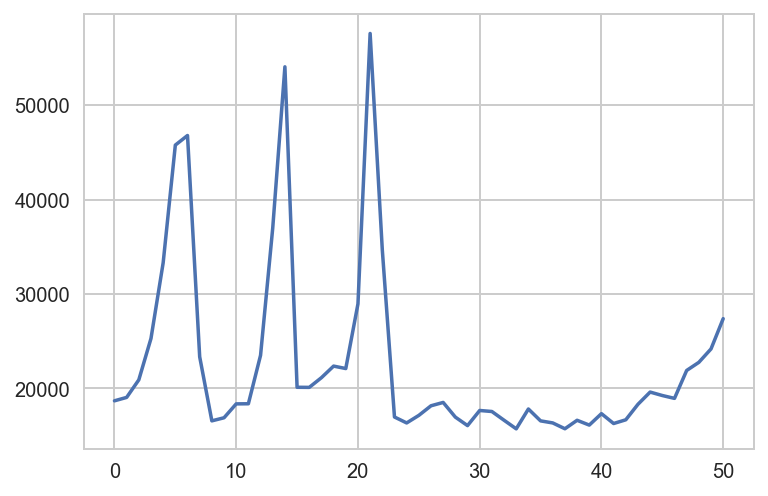

In [45]:
df1111.Weekly_Sales.plot()

In [52]:
from sklearn.preprocessing import normalize

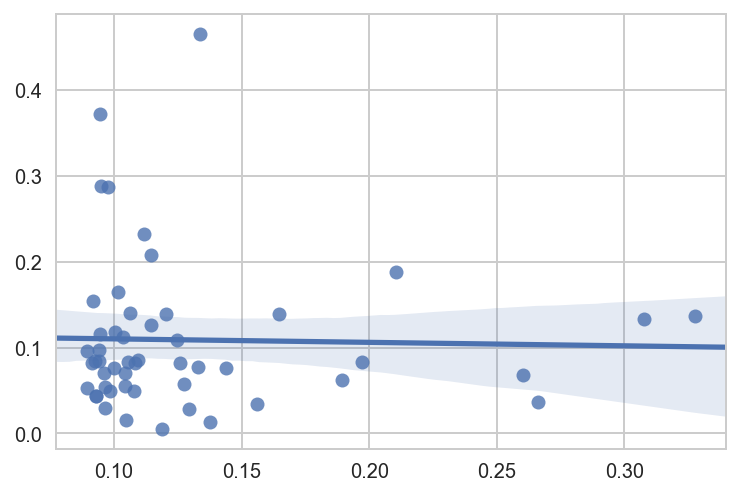

In [68]:
v1 = normalize(df1111.Weekly_Sales.values.reshape(1, -1)).ravel()
v2 = normalize(df1111.MarkDown1.values.reshape(1, -1)).ravel()
sns.regplot(v1, v2)

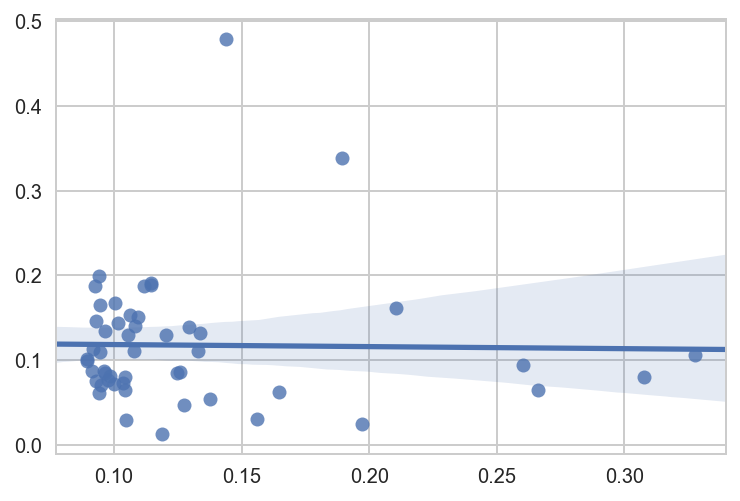

In [72]:
v1 = normalize(df1111.Weekly_Sales.values.reshape(1, -1)).ravel()
v2 = normalize(df1111.MarkDown5.values.reshape(1, -1)).ravel()
sns.regplot(v1, v2)

In [8]:
train_df = merged.drop(columns=['IsHoliday','Store','Dept','week','month','Type','Date','year',
                          'int_week','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5'])
hvec = pd.get_dummies(merged['IsHoliday'], prefix='h')
svec = pd.get_dummies(merged['Store'], prefix='s')
dvec = pd.get_dummies(merged['Dept'], prefix='d')
wvec = pd.get_dummies(merged['week'], prefix='w')
mvec = pd.get_dummies(merged['month'], prefix='m')
tvec = pd.get_dummies(merged['Type'], prefix='t')
train_df = pd.concat([train_df, hvec, svec, dvec, wvec, mvec, tvec], axis=1)

In [9]:
test_sample = train_df.drop(index=train.index).reset_index(drop=True)

In [10]:
len(train_df), len(test_sample)

(536634, 115064)

In [15]:
X = train_df.iloc[train.index].drop(columns=['Weekly_Sales'])
y = train_df.iloc[train.index]['Weekly_Sales']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
xgb1 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, n_jobs=-1)
xgb1.fit(X_train, y_train)
preds = xgb1.predict(X_train)

In [21]:
w = (X_train.h_True * 4 + 1).values
score = np.dot(w, np.abs(preds - y_train.values)) / w.sum()
print ("WMAE Value For XGBoost: ", score)

WMAE Value For XGBoost:  6084.0438658501


In [22]:
impordf = pd.DataFrame([[col, impo] for impo, col in zip(xgb1.feature_importances_.tolist(), X_train.columns)])

In [23]:
impordf.sort_values(1, ascending=False).head()

,0,1
2,CPI,0.259920
4,Size,0.148618
3,Unemployment,0.109797
0,Temperature,0.091838
1,Fuel_Price,0.053339


In [55]:
Xt = test_sample.drop(columns=['Weekly_Sales'])
yhat = xgb1.predict(Xt)

In [56]:
test_sample['Weekly_Sales'] = pd.Series(yhat)

In [57]:
def make_submission(x):
    return '{}_{}_{}'.format(x['Store'], x['Dept'], x['Date'].strftime('%Y-%m-%d'))

In [70]:
test_sample['Date'] = test['Date']
test_sample['Store'] = test['Store']
test_sample['Dept'] = test['Dept']

In [71]:
result = test_sample.apply(make_submission, axis=1)
result = pd.concat([result, test_sample['Weekly_Sales']], axis=1).rename(columns={0:'id'})
result.to_csv('data/sub.csv', index=False)

- Markdown1~5 데이터는 2011년 11월 4일 이전으로는 모두 null값으로 분석에서 제외했다
- Store, Dept, Type, IsHoliday, week, month를 onehotvector로 변경하여 새로운 변수를 추가했다
- Xgboost를 사용하여 기본적으로 분석해봤으나 결과는 너무 좋지 않다

score = 23451.53163 <br>
rate = 680 / 691 

### lag를 추가하여 다시한번 regression을 시도한다
- lag 4, 12, 26, 52 를 추가

In [24]:
test.Date.unique()

array(['2012-11-02T00:00:00.000000000', '2012-11-09T00:00:00.000000000',
       '2012-11-16T00:00:00.000000000', '2012-11-23T00:00:00.000000000',
       '2012-11-30T00:00:00.000000000', '2012-12-07T00:00:00.000000000',
       '2012-12-14T00:00:00.000000000', '2012-12-21T00:00:00.000000000',
       '2012-12-28T00:00:00.000000000', '2013-01-04T00:00:00.000000000',
       '2013-01-11T00:00:00.000000000', '2013-01-18T00:00:00.000000000',
       '2013-01-25T00:00:00.000000000', '2013-02-01T00:00:00.000000000',
       '2013-02-08T00:00:00.000000000', '2013-02-15T00:00:00.000000000',
       '2013-02-22T00:00:00.000000000', '2013-03-01T00:00:00.000000000',
       '2013-03-08T00:00:00.000000000', '2013-03-15T00:00:00.000000000',
       '2013-03-22T00:00:00.000000000', '2013-03-29T00:00:00.000000000',
       '2013-04-05T00:00:00.000000000', '2013-04-12T00:00:00.000000000',
       '2013-04-19T00:00:00.000000000', '2013-04-26T00:00:00.000000000',
       '2013-05-03T00:00:00.000000000', '2013-05-10

In [330]:
lag4 = merged.copy()  
lag4 = lag4.drop(columns=['IsHoliday','week','month','Type','Date','year',
                          'Size','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5','CPI','Unemployment'])
lag4 = lag4.rename(columns={ c:'{}_p4'.format(c) for c in lag4.columns if c not in ['Store','Dept','int_week']})

In [331]:
train_df_lag = merged.drop(columns=['IsHoliday','Type','year',
                          'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5','CPI','Unemployment'])
hvec = pd.get_dummies(merged['IsHoliday'], prefix='h')
svec = pd.get_dummies(merged['Store'], prefix='s')
dvec = pd.get_dummies(merged['Dept'], prefix='d')
wvec = pd.get_dummies(merged['week'], prefix='w')
mvec = pd.get_dummies(merged['month'], prefix='m')
tvec = pd.get_dummies(merged['Type'], prefix='t')
train_df_lag = pd.concat([train_df_lag, hvec, svec, dvec, wvec, mvec, tvec], axis=1)

In [332]:
from tqdm import tqdm_notebook

In [333]:
concat_res = []
for s in tqdm_notebook(train_df_lag['Store'].value_counts().sort_index().index):
    for d in train_df_lag['Dept'].value_counts().sort_index().index:
        
        tmp_lag = lag4[(lag4['Store']==s)&(lag4['Dept']==d)]
        tmp_train = train_df_lag[(train_df_lag['Store']==s)&(train_df_lag['Dept']==d)]

        tmp_train = tmp_train.reset_index(drop=True)

        nl = 4
        for n in range(nl):
            tmp_lag.loc[-(n+1)]=0

        tmp_lag = tmp_lag.sort_index()
        tmp_lag = tmp_lag.reset_index(drop=True)
        tmp_lag = tmp_lag.loc[:len(tmp_lag) - nl-1]

        mlag = pd.concat([tmp_train,tmp_lag], axis=1)
        concat_res.append(mlag)

In [334]:
tmp = pd.concat(concat_res)

In [335]:
len(tmp)

536634

In [366]:
mlag4 = tmp[~((tmp.Weekly_Sales_p4 == 0)&(tmp.Temperature_p4==0)&(tmp.Fuel_Price_p4==0))]

In [367]:
dcol = mlag4[['Store','Dept','int_week']]
dcol = dcol.T.iloc[[0,2,4]].T

In [368]:
mlag = mlag4.drop(columns=['Store','Dept','int_week'])

In [369]:
train_xg = mlag[mlag.Date < '2012-11-02']

In [370]:
test_xg = mlag[mlag.Date > '2012-11-01']

In [348]:
X = mlag.drop(columns=['Weekly_Sales','Date'])
y = mlag['Weekly_Sales']

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [353]:
xgb2 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, n_jobs=-1)
xgb2.fit(X_train, y_train)
preds = xgb2.predict(X_train)

In [354]:
w = (X_train.h_True * 4 + 1).values
score = np.dot(w, np.abs(preds - y_train.values)) / w.sum()
print ("WMAE Value For XGBoost: ", score)

WMAE Value For XGBoost:  2010.345669655781


In [355]:
impordf = pd.DataFrame([[col, impo] for impo, col in zip(xgb2.feature_importances_.tolist(), X_train.columns)])

In [356]:
impordf.sort_values(1, ascending=False).head()

,0,1
200,Weekly_Sales_p4,0.210127
3,week,0.108471
0,Temperature,0.062999
202,Fuel_Price_p4,0.060954
2,Size,0.048004


- lag4의 중요도가 가장 높다

In [446]:
tmp = mlag4[mlag4.Date > '2012-11-01']

In [447]:
tmp = tmp.reset_index(drop=True)

In [448]:
X_train.shape

(418742, 203)

In [449]:
Xt = test_xg.drop(columns=['Date','Weekly_Sales'])

In [450]:
preds = xgb2.predict(Xt)

In [451]:
len(preds)

114992

In [452]:
len(sample)

115064

In [453]:
tmp['Weekly_Sales'] = preds

In [454]:
sdc = tmp[['Store','Dept']].T.iloc[[0, 2]].T

In [455]:
tmp = tmp.drop(columns=['Store','Dept'])

In [456]:
tmp['Store'] = sdc['Store']
tmp['Dept'] = sdc['Dept']

In [467]:
sample['Store'] = sample.Id.map(lambda x: x.split('_')[0])
sample['Dept'] = sample.Id.map(lambda x: x.split('_')[1])
sample['Date'] = sample.Id.map(lambda x: x.split('_')[2])
sample['Date'] = pd.to_datetime(sample['Date'])
sample['Store'] = sample['Store'].astype(int)
sample['Dept'] = sample['Dept'].astype(int)

In [470]:
len(sample), len(tmp)

(115064, 114992)

In [486]:
result = sample.merge(tmp, how='left',on=['Store','Dept','Date'])

In [487]:
result = result[['Id','Weekly_Sales_y']].rename(columns={'Weekly_Sales_y':'Weekly_Sales'})
result.Weekly_Sales = result.Weekly_Sales.fillna(0)

In [488]:
result.to_csv('data/sub2.csv', index=False)

- 4주전 데이터를 추가하여 과거 판매량이 얼마나 영향을 미치는지 확인하였다
- 회귀분석보다 시계열분석으로 접근한다

score = 20818.13186 <br>
rate = 631 / 691